In [156]:
import pandas as pd
import mysql.connector

con = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')

In [140]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import math

In [157]:
query = """
SELECT itb.*, bmg.*, tmb.release_date, tmb.worldwide_gross, tmb.production_budget
FROM movies.imdb_title_basics itb
JOIN movies.bom_movie_gross bmg
ON itb.primary_title = bmg.title
JOIN movies.tn_movie_budgets tmb
ON tmb.movie = bmg.title
"""
df =pd.read_sql_query(query, con)
df.head()
df.start_year.unique()

array([2010, 2013, 2018, 2017, 2014, 2012, 2015, 2019, 2011, 2016, 2020],
      dtype=int64)

In [71]:
df_genre = df.genres.apply(lambda x: x.split(',')).apply(pd.Series) \
         .merge(df, left_index = True, right_index = True).drop(["genres", 'primary_title', 'title'], axis = 1) \
       .melt(id_vars = ['tconst', 'original_title', 'start_year', 'runtime_minutes', 'studio', \
         'domestic_gross', 'foreign_gross', 'year', 'release_date', 'worldwide_gross', 'production_budget'], \
          value_name = "genre").dropna(subset=['genre']).sort_values(by = 'genre')

In [72]:
df_genre['worldwide_gross'] = df_genre['worldwide_gross'].str.replace("$", "").str.replace(',','').astype(int)
df_genre['production_budget'] = df_genre['production_budget'].str.replace("$", "").str.replace(',','').astype(int)

In [69]:
df_genre.head()
df_genre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3885 entries, 1541 to 3984
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tconst             3885 non-null   object 
 1   original_title     3885 non-null   object 
 2   start_year         3885 non-null   int64  
 3   runtime_minutes    3767 non-null   float64
 4   title              3885 non-null   object 
 5   studio             3885 non-null   object 
 6   domestic_gross     3882 non-null   float64
 7   foreign_gross      3361 non-null   float64
 8   year               3885 non-null   int64  
 9   release_date       3885 non-null   object 
 10  worldwide_gross    3885 non-null   int32  
 11  production_budget  3885 non-null   int32  
 12  variable           3885 non-null   object 
 13  genre              3885 non-null   object 
dtypes: float64(3), int32(2), int64(2), object(7)
memory usage: 424.9+ KB


In [154]:
df_genre['roi'] = (df_genre.worldwide_gross - df_genre.production_budget)/df_genre.production_budget
df_genre['decade'] = df_genre.year.apply(lambda x: math.floor(x/10)*10)
df_genre.decade.unique()

array([2010], dtype=int64)

In [144]:
df_genre_f = df_genre.loc[(df_genre['worldwide_gross'] > 1000000)]
df_genre_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3666 entries, 508 to 3984
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tconst             3666 non-null   object 
 1   original_title     3666 non-null   object 
 2   start_year         3666 non-null   int64  
 3   runtime_minutes    3557 non-null   float64
 4   studio             3666 non-null   object 
 5   domestic_gross     3663 non-null   float64
 6   foreign_gross      3293 non-null   float64
 7   year               3666 non-null   int64  
 8   release_date       3666 non-null   object 
 9   worldwide_gross    3666 non-null   int32  
 10  production_budget  3666 non-null   int32  
 11  variable           3666 non-null   object 
 12  genre              3666 non-null   object 
 13  roi                3666 non-null   float64
 14  decade             3666 non-null   int64  
dtypes: float64(4), int32(2), int64(3), object(6)
memory usage: 429.6+ KB


23


Text(0.5, 1.0, 'Mean ROI per Genre')

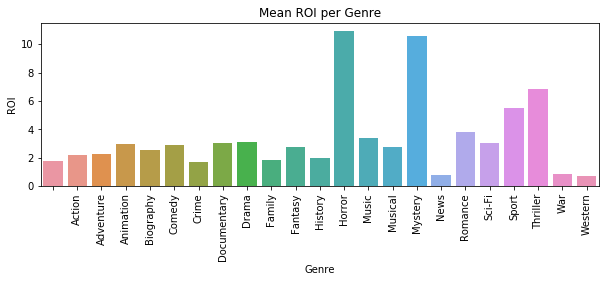

In [135]:
gb_genre=(df_genre_f.groupby(['genre']).mean())
print(len(gb_genre))
xvals = list(range(1, len(gb_genre)+1))
#print(xvals)
yvals = gb_genre['roi'].values
#print(yvals)
labels = gb_genre.index
#print(labels)
plt.figure(figsize = (10,3))
genre_plot = sns.barplot(x=labels, y=yvals, orient = 'v')
genre_plot.set_xticklabels(genre_plot.get_xticklabels(), rotation=90, horizontalalignment='center')
plt.xlabel('Genre')
plt.ylabel('ROI')
plt.title('Mean ROI per Genre')


23


Text(0.5, 1.0, 'Music ROI per Genre')

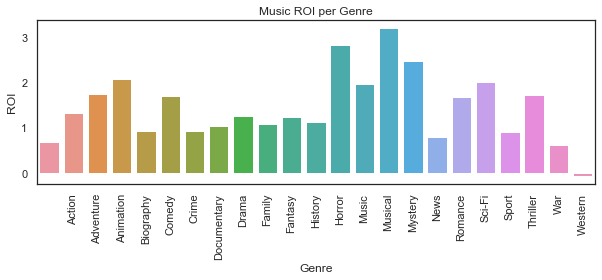

In [228]:
gb_genre=(df_genre_f.groupby(['genre']).median())
print(len(gb_genre))
xvals = list(range(1, len(gb_genre)+1))
#print(xvals)
yvals = gb_genre['roi'].values
#print(yvals)
labels = gb_genre.index
#print(labels)
plt.figure(figsize = (10,3))
genre_plot = sns.barplot(x=labels, y=yvals, orient = 'v')
genre_plot.set_xticklabels(genre_plot.get_xticklabels(), rotation=90, horizontalalignment='center')
plt.xlabel('Genre')
plt.ylabel('ROI')
plt.title('Music ROI per Genre')

In [200]:
df_genre_f_dg =  df_genre.loc[(df_genre['roi'] < 10)]

In [215]:
df_genre_f.groupby(['genre']).mean()

,start_year,runtime_minutes,domestic_gross,foreign_gross,year,worldwide_gross,production_budget,roi,decade
genre,,,,,,,,,
,2015.565217,80.000000,8.361278e+07,1.315750e+08,2012.565217,1.941175e+08,6.723478e+07,1.766504,2011.521739
Action,2013.985222,113.417085,9.165836e+07,1.576357e+08,2013.852217,2.480290e+08,8.146780e+07,2.159096,2012.179803
Adventure,2014.072555,110.100946,1.279465e+08,2.322090e+08,2014.025237,3.598985e+08,1.078640e+08,2.285117,2012.287066
Animation,2014.081633,94.010417,1.413357e+08,2.569802e+08,2014.132653,3.928097e+08,9.985714e+07,2.984225,2012.346939
Biography,2014.503650,112.291971,4.442763e+07,5.733118e+07,2014.496350,9.192240e+07,2.888843e+07,2.526884,2012.773723
Comedy,2013.583158,101.814655,6.487360e+07,9.093805e+07,2013.677895,1.473856e+08,4.294404e+07,2.911964,2012.094737
Crime,2013.730000,111.492462,4.259617e+07,4.594548e+07,2013.820000,9.650114e+07,3.596154e+07,1.668242,2012.050000
Documentary,2014.595960,62.152941,5.130045e+07,6.630021e+07,2013.393939,1.120309e+08,3.687419e+07,3.023805,2011.767677
Drama,2013.777927,110.280112,3.923494e+07,5.607299e+07,2013.741588,8.689769e+07,2.963282e+07,3.101990,2012.086137


In [205]:
df_genre_f_dg = df_genre_f_dg.drop(df_genre_f_dg[df_genre_f_dg['genre'] == 'News'].index)
df_genre_f_dg = df_genre_f_dg.drop(df_genre_f_dg[df_genre_f_dg['genre'] == 'War'].index)
df_genre_f_dg = df_genre_f_dg.drop(df_genre_f_dg[df_genre_f_dg['genre'] == 'Musical'].index)
df_genre_f_dg = df_genre_f_dg.drop(df_genre_f_dg[df_genre_f_dg['genre'] == 'Western'].index)


Text(0.5, 0, 'ROI')

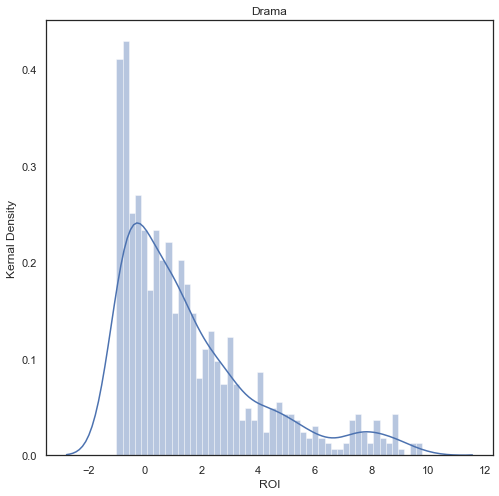

In [207]:
plotdf = df_genre_f_dg[['genre', 'roi']]
plotdf = plotdf.reset_index()
indexer = 8
genre_list = df_genre_f_dg.genre.unique()
total_dict= {}
for genre_type in genre_list: 
    total_dict[genre_type] = df_genre_f_dg.loc[df_genre_f_dg.genre == genre_type][['tconst', 'roi', 'genre']]
g = total_dict[genre_list[indexer]]['roi']

y=g.tolist()
# print(len(y))
# print(y)
#plt.hist(y, bins = 20)
# plt.title(genre_list[4])
new_fig = plt.figure(figsize=(8,8))

sns.distplot(y, bins =50, kde=True)
plt.title(genre_list[indexer])
plt.ylabel('Kernal Density')
plt.xlabel('ROI')

# sns.distplot(total_dict[genre_list[5]]['total_gross'], bins =50, norm_hist=1 )
# sns.distplot(total_dict[genre_list[6]]['total_gross'], bins =50, norm_hist=1 )

Text(0.5, 8.960000000000157, 'ROI')

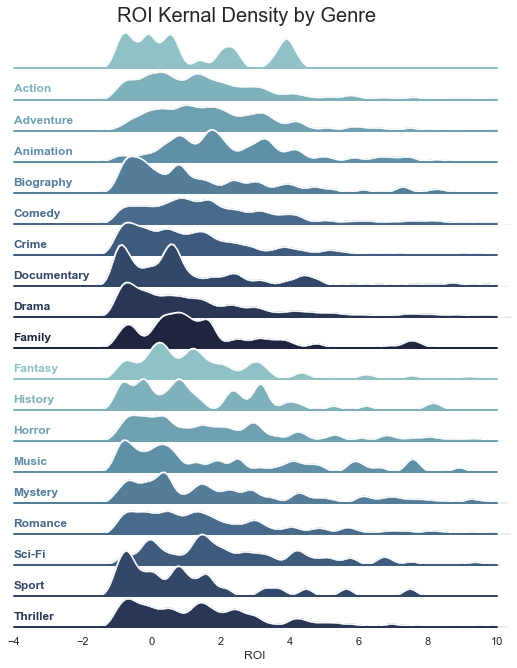

In [227]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
# rs = np.random.RandomState(1979)
# x = y
# print(x)
# g = np.tile(list("ABCDEFGHIJ"), 50)
# df = pd.DataFrame(dict(x=x, g=g))
# m = df.g.map(ord)
# df["x"] += m
# Initialize the FacetGrid object

pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(plotdf, row="genre", hue="genre", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "roi", clip_on=False, shade=True, alpha=1, lw=1, bw=.2)
g.map(sns.kdeplot, "roi", clip_on=False, color="w", lw=1.5, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "genre")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.4)
g.set(ylim=(0, .5))
g.set(xlim=(-4, 10))

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.text(2.75, 5.85, 'ROI Kernal Density by Genre',
         horizontalalignment='center',
         fontsize=20)
plt.xlabel('ROI')


In [17]:
print(df.loc[df['primary_profession'].isin(['composer'])])
df.primary_profession

Empty DataFrame
Columns: [nconst, primary_name, birth_year, death_year, primary_profession, known_for_titles]
Index: []


0           miscellaneous,production_manager,producer
1          composer,music_department,sound_department
2                          miscellaneous,actor,writer
3    camera_department,cinematographer,art_department
4    production_designer,art_department,set_decorator
Name: primary_profession, dtype: object

In [24]:
df1 = df.primary_profession.apply(lambda x: x.split(',')).apply(pd.Series)

,0,1,2
0,miscellaneous,production_manager,producer
1,composer,music_department,sound_department
2,miscellaneous,actor,writer
3,camera_department,cinematographer,art_department
4,production_designer,art_department,set_decorator


In [32]:
df1.merge(df, left_index = True, right_index = True).drop(["primary_profession"], axis = 1) \
.melt(id_vars = ['nconst', 'primary_name', 'birth_year', 'death_year', 'known_for_titles'], 
        value_name = "profession").sort_values(by = 'nconst')

,nconst,primary_name,birth_year,death_year,known_for_titles,variable,profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"tt0837562,tt2398241,tt0844471,tt0118553",0,miscellaneous
5,nm0061671,Mary Ellen Bauder,NaN,NaN,"tt0837562,tt2398241,tt0844471,tt0118553",1,production_manager
10,nm0061671,Mary Ellen Bauder,NaN,NaN,"tt0837562,tt2398241,tt0844471,tt0118553",2,producer
1,nm0061865,Joseph Bauer,NaN,NaN,"tt0896534,tt6791238,tt0287072,tt1682940",0,composer
6,nm0061865,Joseph Bauer,NaN,NaN,"tt0896534,tt6791238,tt0287072,tt1682940",1,music_department
11,nm0061865,Joseph Bauer,NaN,NaN,"tt0896534,tt6791238,tt0287072,tt1682940",2,sound_department
2,nm0062070,Bruce Baum,NaN,NaN,"tt1470654,tt0363631,tt0104030,tt0102898",0,miscellaneous
7,nm0062070,Bruce Baum,NaN,NaN,"tt1470654,tt0363631,tt0104030,tt0102898",1,actor
12,nm0062070,Bruce Baum,NaN,NaN,"tt1470654,tt0363631,tt0104030,tt0102898",2,writer
3,nm0062195,Axel Baumann,NaN,NaN,"tt0114371,tt2004304,tt1618448,tt1224387",0,camera_department


In [3]:
con1 = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')

OperationalError: 1040 (08004): Too many connections

In [6]:
query = """
SELECT *
FROM movies.imdb_title_basics itb
JOIN movies.bom_movie_gross bmg
ON itb.primary_title = bmg.title
"""
df =pd.read_sql_query(query, con)


In [10]:
df.info()
df.to_csv('itb join bmg')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3509 entries, 0 to 3508
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           3509 non-null   object 
 1   primary_title    3509 non-null   object 
 2   original_title   3509 non-null   object 
 3   start_year       3509 non-null   int64  
 4   runtime_minutes  3334 non-null   float64
 5   genres           3509 non-null   object 
 6   title            3509 non-null   object 
 7   studio           3509 non-null   object 
 8   domestic_gross   3484 non-null   float64
 9   foreign_gross    2117 non-null   float64
 10  year             3509 non-null   int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 301.7+ KB


In [11]:
df.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,title,studio,domestic_gross,foreign_gross,year
0,tt0315642,Wazir,Wazir,2016,103.0,"Action,Crime,Drama",Wazir,Relbig.,1100000.0,NaN,2016
1,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",On the Road,IFC,744000.0,8000000.0,2012
2,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",The Secret Life of Walter Mitty,Fox,58200000.0,129900000.0,2013
3,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",A Walk Among the Tombstones,Uni.,26300000.0,26900000.0,2014
4,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",Jurassic World,Uni.,652300000.0,1.0,2015


In [89]:
df1 = df.genres.apply(lambda x: x.split(',')).apply(pd.Series) \
.merge(df, left_index = True, right_index = True).drop(["genres"], axis = 1) \
.melt(id_vars = ['tconst', 'primary_title', 'original_title', 'start_year', 'runtime_minutes', 'title', 'studio', \
                 'domestic_gross', 'foreign_gross', 'year'], \
        value_name = "genre").dropna(subset=['genre']).sort_values(by = 'genre')

In [ ]:
df1 = df.known_for_titles.apply(lambda x: x.split(',')).apply(pd.Series) \
.merge(df, left_index = True, right_index = True).drop(["known_for_titles"], axis = 1) \
.melt(id_vars = ['tconst', 'primary_title', 'original_title', 'start_year', 'runtime_minutes', 'title', 'studio', \
                 'domestic_gross', 'foreign_gross', 'year'], \
        value_name = "genre").dropna(subset=['genre']).sort_values(by = 'genre')

In [90]:
df1['total_gross'] = df1.domestic_gross + df1.foreign_gross

In [129]:
df2 =df1.dropna(subset =['total_gross'])
df2

,tconst,primary_title,original_title,start_year,runtime_minutes,title,studio,domestic_gross,foreign_gross,year,variable,genre,total_gross
1856,tt2495188,Joy,Hara,2012,80.0,Joy,Fox,56500000.0,44700000.0,2015,0,,101200000.0
2902,tt5213284,Unknown,Unknown,2015,NaN,Unknown,WB,63700000.0,67099999.0,2011,0,,130799999.0
1704,tt2339048,Transcendence,Transcendence,2012,45.0,Transcendence,WB,23000000.0,80000000.0,2014,0,,103000000.0
3064,tt5877156,Unknown,Unknown,2017,NaN,Unknown,WB,63700000.0,67099999.0,2011,0,,130799999.0
3272,tt6858500,Robin Hood,Robin Hood,2018,NaN,Robin Hood,Uni.,105300000.0,216400000.0,2010,0,,321700000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8721,tt2338846,Gold,Gold,2013,101.0,Gold,Wein.,7200000.0,7700000.0,2017,2,Western,14900000.0
7694,tt1533117,Let the Bullets Fly,Rang zi dan fei,2010,132.0,Let the Bullets Fly,Vari.,63000.0,104300000.0,2012,2,Western,104363000.0
7870,tt1629705,Blackthorn,Blackthorn,2011,102.0,Blackthorn,Magn.,201000.0,423000.0,2011,2,Western,624000.0
4179,tt1530983,Red Hill,Red Hill,2010,95.0,Red Hill,Strand,21100.0,300000.0,2010,1,Western,321100.0


In [134]:
plotdf = df2[['genre', 'total_gross']]
plotdf = plotdf.reset_index()


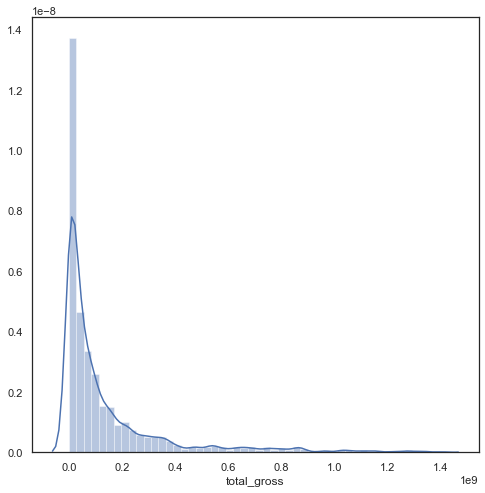

In [151]:
plotdf = df2[['genre', 'total_gross']]
plotdf = plotdf.reset_index()

genre_list = df1.genre.unique()
total_dict= {}
for genre_type in genre_list: 
    total_dict[genre_type] = df2.loc[df2.genre == genre_type][['tconst', 'total_gross', 'genre']]
g = total_dict[genre_list[4]]['total_gross']
y=g.tolist()
# print(len(y))
# print(y)
#plt.hist(y, bins = 20)
# plt.title(genre_list[4])
new_fig = plt.figure(figsize=(8,8))

sns.distplot(plotdf['total_gross'], bins =50, kde=True)
# sns.distplot(total_dict[genre_list[5]]['total_gross'], bins =50, norm_hist=1 )
# sns.distplot(total_dict[genre_list[6]]['total_gross'], bins =50, norm_hist=1 )

In [88]:
df1.groupby('genre').mean()

AttributeError: 'NoneType' object has no attribute 'groupby'

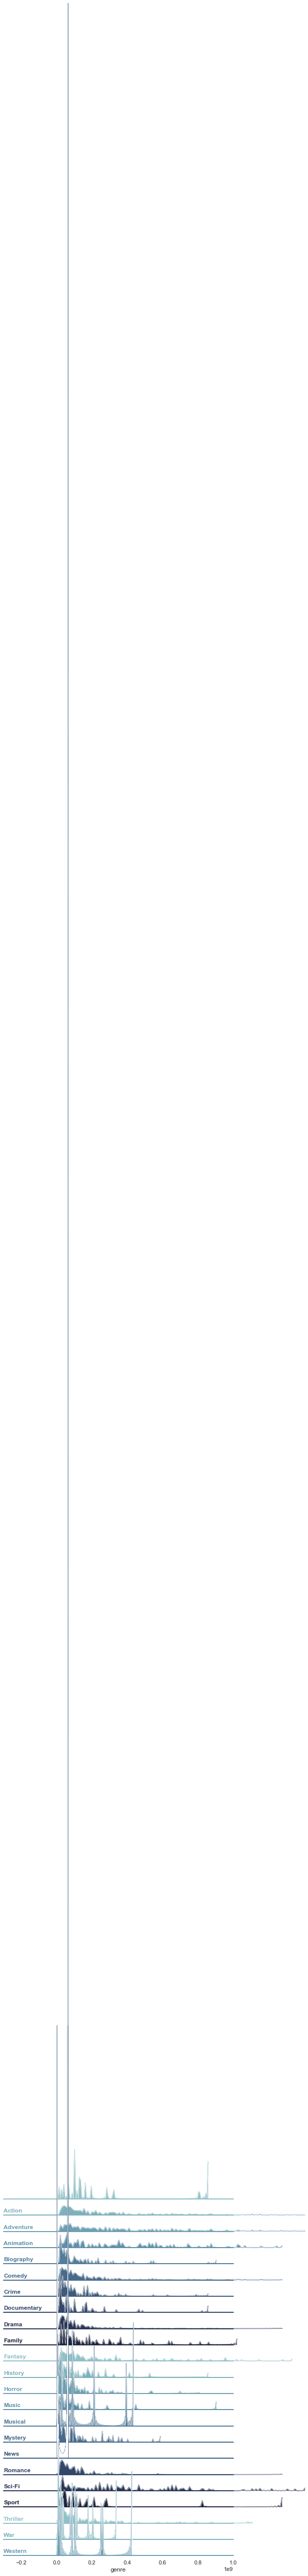

In [150]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
# rs = np.random.RandomState(1979)
# x = y
# print(x)
# g = np.tile(list("ABCDEFGHIJ"), 50)

# df = pd.DataFrame(dict(x=x, g=g))

# m = df.g.map(ord)

# df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(plotdf, row="genre", hue="genre", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "total_gross", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "total_gross", clip_on=False, color="w", lw=.5, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "genre")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)
g.set(ylim=(0, .00000001))
g.set(xlim=(-300000000, 1000000000))

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)


C:\Users\kyled\anaconda3\lib\site-packages\seaborn\axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
C:\Users\kyled\anaconda3\lib\site-packages\seaborn\axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()


,x,g
0,64.038123,A
1,66.147050,B
2,66.370011,C
3,68.791019,D
4,70.583534,E


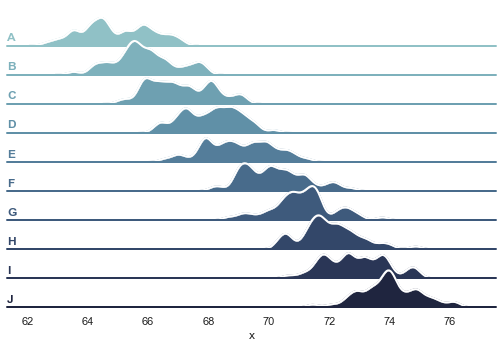

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
df.head()

In [ ]:
SELECT *
FROM movies.imdb_title_basics itb
JOIN movies.bom_movie_gross bmg
ON itb.primary_title = bmg.title
JOIN movies.tn_movie_budgets tmb
ON tmb.movie = bmg.titleimdb_title_akas